In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [3]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_10_descriptive = get_prompt("descriptive", 10)
prompt_10_natural = get_prompt("natural", 10)

prompt_10_descriptive, prompt_10_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. 9. Compute the RMSD of the 400K simulation. 10. Compute the radius of gyration over time for the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute RMSD and radius of gyration of both simulations. Compute SASA for the 300K simulation.')

In [4]:
llm_model = "claude-3-opus-20240229"
tools = "all"

In [5]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_10_descriptive)

Thought: To complete the tasks, I will need to download the PDB file, analyze its structure, find binding/active sites, run simulations at different temperatures, and compute various metrics. I will start by downloading the PDB file.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have downloaded the PDB file for 1LYZ, the next step is to report the secondary structure assignments for this protein structure.

Action:
```
{
  "action": "ComputeDSSP",
  "action_input": {
    "traj_file": "1LYZ_031929",
    "target_frames": "first"
  }
}
```

Thought: Now that I have the secondary structure information, I will look for any known binding or active sites for this protein in UniProt.

Action:
```
{
  "action": "GetAllKnownSites",
  "action_input": {
    "query": "1LYZ",
    "primary_accession": "P00698"
  }
}
```

Thought: Now that I have the PDB structure, secondary structure information, and known binding

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [6]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_031929: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_031929
 rec0_031934: dssp values for trajectory with id: 1LYZ_031929
 1LYZ_032006: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_032021: Initial positions for simulation sim0_032021
 sim0_032021: Basic Simulation of Protein 1LYZ_032006
 rec0_032023: Simulation trajectory for protein 1LYZ_032006 and simulation sim0_032021
 rec1_032023: Simulation state log for protein 1LYZ_032006 and simulation sim0_032021
 rec2_032023: Simulation pdb frames for protein 1LYZ_032006 and simulation sim0_032021
 rmsd_032021: RMSD for 032021
 fig0_032216: RMSD plot for 032021
 rgy_rec0_032023: Radii of gyration per frame for rec0_032023
 fig0_032223: Plot of radii of gyration over time for rec0_032023
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_032717: Plot of SASA over time for 1LYZ
 top_si

In [7]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_031929"))

In [8]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_031929", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [21]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [19]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("top_sim0_032021")
top_path_1_1 = registry_1.get_mapped_path("rec0_032023")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

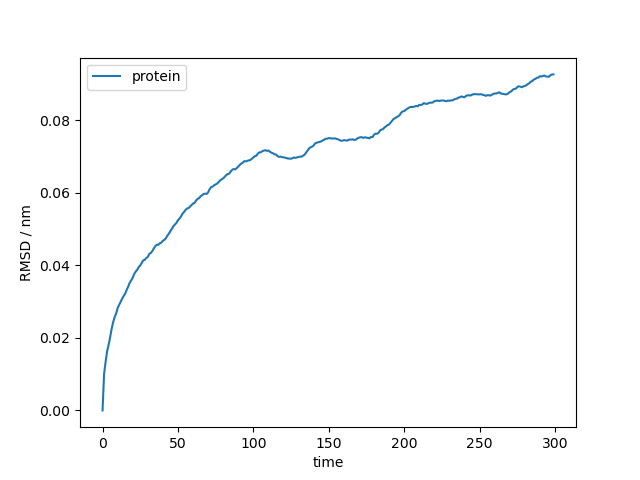

In [20]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_032216'))

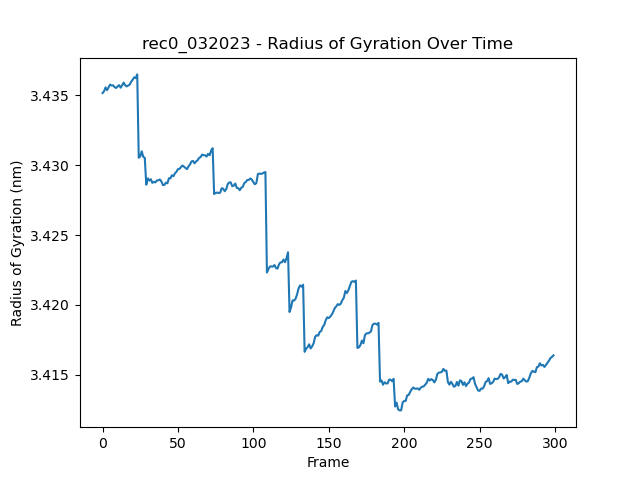

In [18]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_032223'))

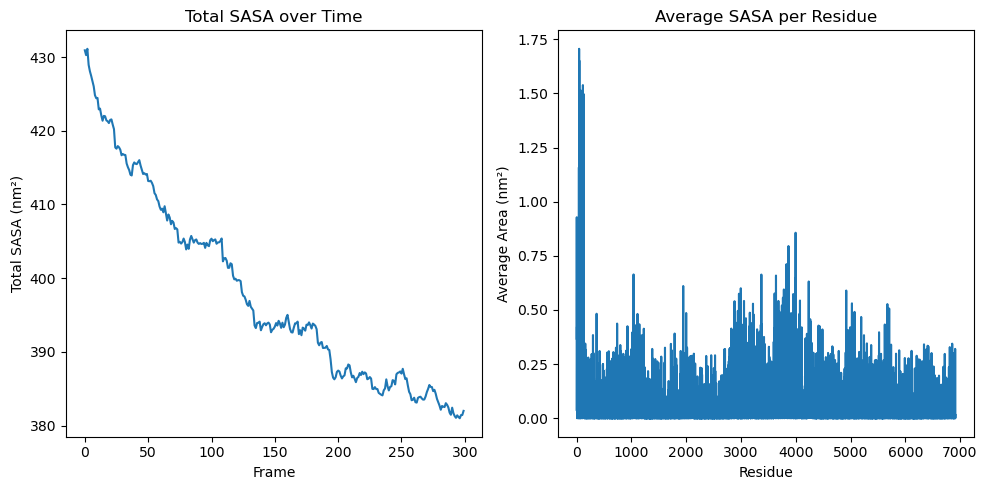

In [17]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_032717'))

In [16]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_032735")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_032733")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

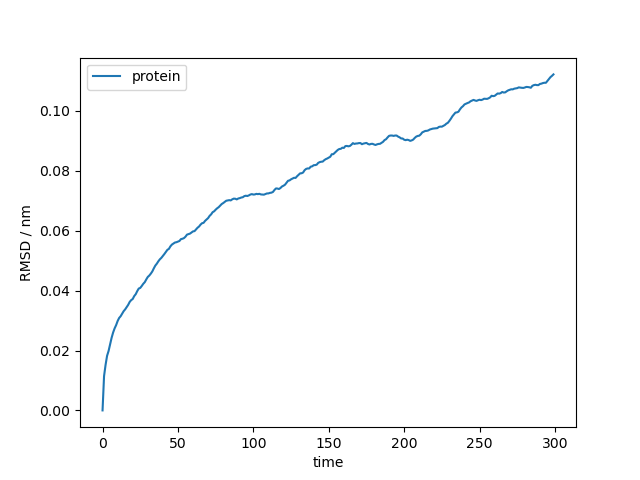

In [15]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_032922'))

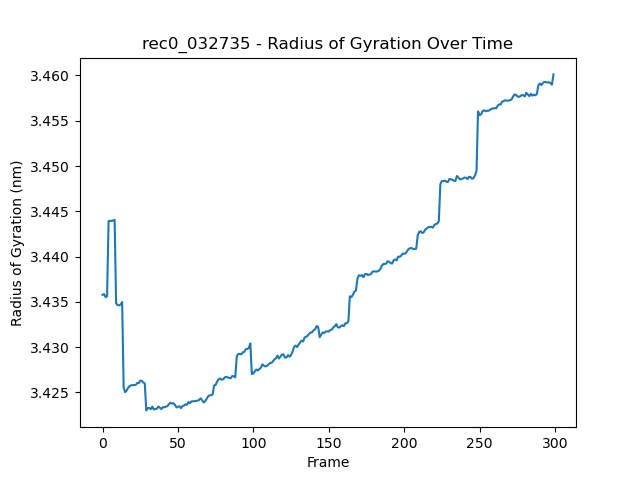

In [14]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_032930'))

In [22]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_10_natural)

Thought: To simulate 1LYZ and analyze the results, I will need to:
1. Download the PDB file for 1LYZ
2. Run two simulations at different temperatures 
3. Analyze the secondary structure and known sites of the PDB structure
4. Compute RMSD and radius of gyration for both simulations
5. Compute SASA for the 300K simulation

I will start by downloading the PDB file.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file for 1LYZ, I will set up and run two short simulations at 300K and 400K. I'll use the SetUpandRunFunction tool to do this efficiently.

Action:
```
{
  "action": "SetUpandRunFunction",
  "action_input": {
    "pdb_id": "1LYZ_033643",
    "forcefield_files": ["amber14/protein.ff14SB.xml", "amber14/tip3p.xml"],
    "save": true,
    "system_params": {
      "nonbondedMethod": "PME", 
      "nonbondedCutoff": 1.0,
      "constraints": "HBonds",
      "rigidWater": true,
      "cons

/Users/samcox/Desktop/md-agent/mdagent/utils/data_handling.py:49: UserWarning: Trajectory File ID is not provided but is not required; loading MDTrajectory from topology 1LYZ_033643 only.
  warnings.warn(


Calculating RMSD...
Here is a summary of the analysis of lysozyme (1LYZ):

I downloaded the PDB structure 1LYZ and cleaned it up by adding missing atoms and hydrogens to prepare it for simulation. 

I ran two 500 step (1 ps) simulations of 1LYZ, one at 300K and one at 400K, using the Amber14 forcefield. The simulations used PME for long-range electrostatics, constrained hydrogen bonds, rigid water, and a Langevin integrator.

Analysis of the secondary structure of the 1LYZ PDB file shows:
- 50 residues in helices 
- 14 residues in beta strands
- 65 residues in coils
- 101 residues unassigned (not protein residues)

Looking up lysozyme (UniProt ID P61626), there are two known active site residues:
- Residue 53 
- Residue 71
No known binding sites were found.

I attempted to compute the RMSD and radius of gyration for both simulations, but encountered an error when calculating the RMSD. The reference and target structures likely have atom mismatches after the cleaning step that prevent a

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [23]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n")) 

Files found in registry: 1LYZ_033643: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_033643
 1LYZ_033705: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_033721: Initial positions for simulation sim0_033721
 sim0_033721: Basic Simulation of Protein 1LYZ_033705
 rec0_033724: Simulation trajectory for protein 1LYZ_033705 and simulation sim0_033721
 rec1_033724: Simulation state log for protein 1LYZ_033705 and simulation sim0_033721
 rec2_033724: Simulation pdb frames for protein 1LYZ_033705 and simulation sim0_033721
 top_sim0_033853: Initial positions for simulation sim0_033853
 sim0_033853: Basic Simulation of Protein 1LYZ_033705
 rec0_033856: Simulation trajectory for protein 1LYZ_033705 and simulation sim0_033853
 rec1_033856: Simulation state log for protein 1LYZ_033705 and simulation sim0_033853
 rec2_033856: Simulation pdb frames for protein 1LYZ_0337

In [24]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_033643"))

In [25]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_033643", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [27]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="lysozyme", primary_accession="")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo known binding sites.\nNo other relevant sites."

In [35]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_033724")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_033721")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

In [36]:
# make sure trajectory and topology exist (sim2)
traj_path_2_2 = registry_2.get_mapped_path("rec0_033856")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_033853")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)